## Descriptive Analytics

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

### Import Data

In [2]:
charging_sessions_data = pd.read_csv("cleaned_data.csv")
weather_data = pd.read_csv("weather_burbank_airport.csv")

charging_sessions_data.head(5)

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,connectionTime_local,disconnectTime_local,doneChargingTime_local,WhPerMile,kWhRequested,milesRequested,minutesAvailable,requestedDeparture
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil...",2020-01-02 05:08:54-08:00,2020-01-02 11:11:15-08:00,2020-01-02 09:31:35-08:00,250.0,25.0,100.0,463.0,2020-01-02 20:51:54
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil...",2020-01-02 05:36:50-08:00,2020-01-02 14:38:21-08:00,2020-01-02 12:18:05-08:00,280.0,70.0,250.0,595.0,2020-01-02 23:31:50
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2020-01-02 05:56:35-08:00,2020-01-02 16:39:22-08:00,2020-01-02 08:35:06-08:00,400.0,8.0,20.0,60.0,2020-01-02 14:56:35
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2020-01-02 05:59:58-08:00,2020-01-02 08:38:39-08:00,2020-01-02 07:18:45-08:00,400.0,8.0,20.0,65.0,2020-01-02 15:04:58
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil...",2020-01-02 06:00:01-08:00,2020-01-02 14:08:40-08:00,2020-01-02 10:17:30-08:00,400.0,16.0,40.0,504.0,2020-01-02 22:24:01


In [22]:
# Due to the export to csv file the right format cannot be kept
# Therefore, the columns with datetime type need to be reformatted
charging_sessions_data["connectionTime"] = pd.to_datetime(charging_sessions_data["connectionTime"])
charging_sessions_data["disconnectTime"] = pd.to_datetime(charging_sessions_data["disconnectTime"])
charging_sessions_data["doneChargingTime"] = pd.to_datetime(charging_sessions_data["doneChargingTime"])

charging_sessions_data.dtypes

id                                     object
connectionTime            datetime64[ns, UTC]
disconnectTime            datetime64[ns, UTC]
doneChargingTime          datetime64[ns, UTC]
kWhDelivered                          float64
sessionID                              object
siteID                                  int64
spaceID                                object
stationID                              object
timezone                               object
userID                                 object
userInputs                             object
connectionTime_local                   object
disconnectTime_local                   object
doneChargingTime_local                 object
WhPerMile                             float64
kWhRequested                          float64
milesRequested                        float64
minutesAvailable                      float64
requestedDeparture                     object
hour                                    int32
weekday                           

### Operational Performance and Statistics on Charging Hubs
1. **Temporal Patterns and Seasonality**
* Demonstrate in a figure how the number of charging events varies during 
    1. the day
    2. the week 
    3. between seasons **(Karoline)**
* Note down observed patterns and possible explanation for them
2. **Key Performance Indicators (KPIs)**
* Define three time-dependent KPIs (to include in a dashboard for the hub operator):
    1. Peak and Off-Utilization Time (per Site) **(Marietta)**
    2. Idle Time per Hour per SiteID (disconnect - chargingdone) **(Angela)**
    3. Average Energy Delivered per Session per SiteID per Hour **(CoCo)**
* Requirements for KPIs:
    * Must provide an immediate overview of the current hub operation
    * Show how the hub operation is doing in terms of *utilization or other business-related aspects*
* Provide explanation for each KPI selection in relation to the requirements and if necessary provide references
* Calculate *hourly values* for the KPIs and visualize them over time
* Note down observed trends and possible explainations for them
3. **Site Characteristics** ***(Simon)***
* Find out which of the two sites is supplying the private and public charging hub data
* Combine data from the tasks before to determine the difference in the operation of private and public charging hub data
* Note down explanation and reasoning behind the decision

### 1. Temporal Patterns and Seasonality

#### 1.1. Number of Charging Events during the Day

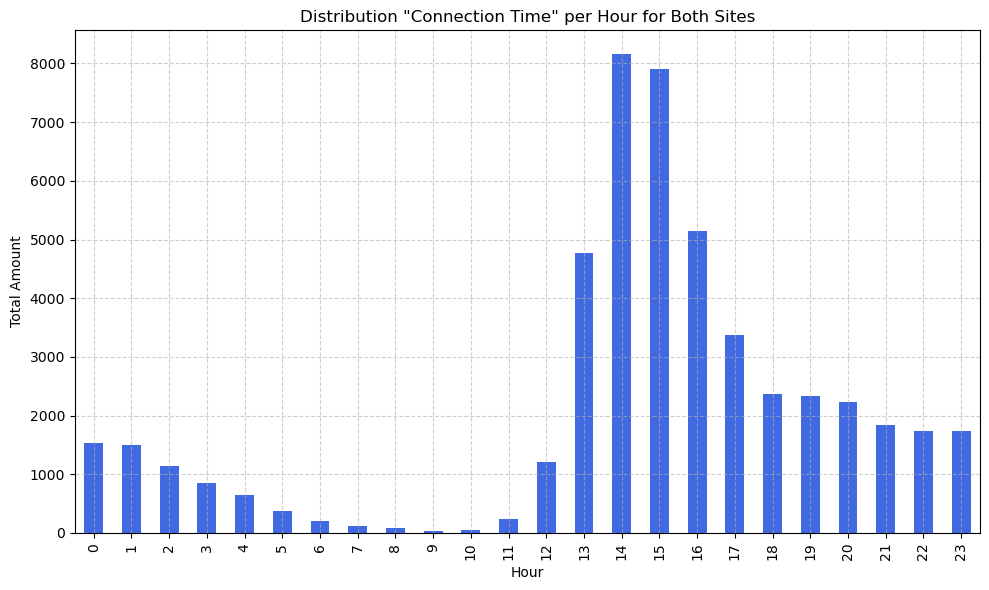

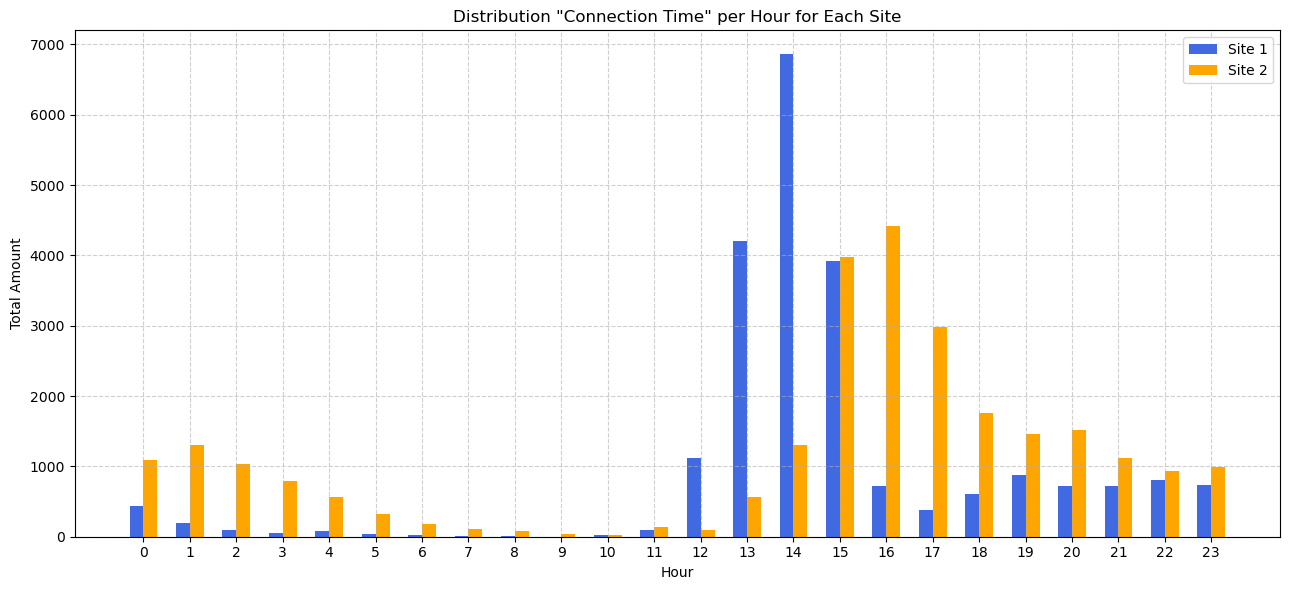

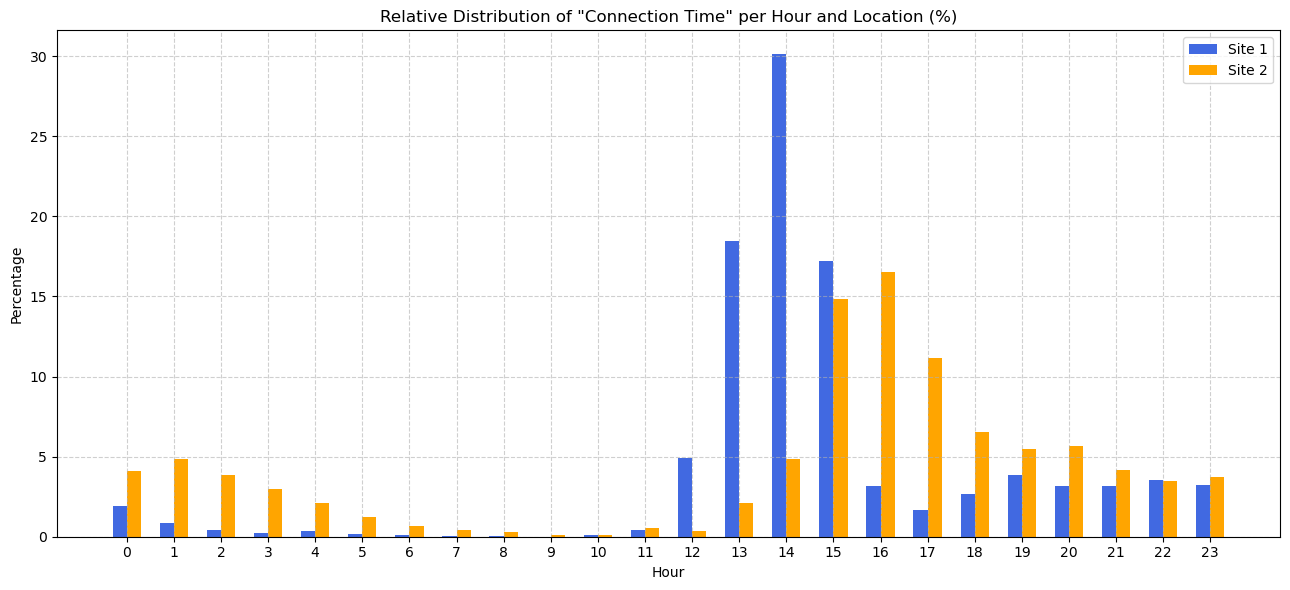

In [4]:
# Demonstrate how the number of charging events varies during the day

# Retrieve the hour
charging_sessions_data['hour'] = charging_sessions_data['connectionTime'].dt.hour

# Count the frequency per hour
hourly_counts = charging_sessions_data['hour'].value_counts().sort_index()

# Calculation of the absolute distribution per hour and location
absolute_counts = charging_sessions_data.groupby('siteID')['hour'].value_counts().unstack(fill_value=0).sort_index()

# Calculation of the relative distribution (percentage)
relative_counts = absolute_counts.div(absolute_counts.sum(axis=1), axis=0) * 100

# Plotting the distribution
# Plotting ConnectionTime per hour for both sites
plt.figure(figsize=(10, 6))
hourly_counts.plot(kind='bar', color='royalblue')
plt.grid(visible=True, linestyle='--', alpha=0.6)

plt.title('Distribution "Connection Time" per Hour for Both Sites')
plt.xlabel('Hour')
plt.ylabel('Total Amount')
plt.xticks(range(24))

plt.tight_layout()
plt.show()


# Plotting Distribution "Connection Time" per hour for each site
bar_width = 0.3  # Adjust bar width as needed
x_indices = absolute_counts.columns  # Extract the hours (assuming columns represent hours)
colors = ['royalblue', 'orange']

plt.figure(figsize=(13, 6))

# Plot bars for each site
for i, (site, color) in enumerate(zip(absolute_counts.index, colors)):
    plt.bar(
        x_indices + i * bar_width,  # Offset for each site's bars
        absolute_counts.loc[site],  # Data for the site
        width=bar_width,
        color=color,
        label=f'Site {site}',
    )

plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.title('Distribution "Connection Time" per Hour for Each Site')
plt.xlabel('Hour')
plt.ylabel('Total Amount')
plt.xticks(x_indices + bar_width * (len(absolute_counts.index) - 1) / 2, x_indices)  # Center x-ticks
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


# Plotting Relative distribution of "Connection Time" per hour and location (%)
x_indices = relative_counts.columns  # Extract the hours (assuming columns represent hours)
plt.figure(figsize=(13, 6))

# Plot bars for each site
for i, (site, color) in enumerate(zip(relative_counts.index, colors)):
    plt.bar(
        x_indices + i * bar_width,  # Offset for each site's bars
        relative_counts.loc[site],  # Percentage data for the site
        width=bar_width,
        color=color,  # Use the color for the current site
        label=f'Site {site}'
    )

plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.title('Relative Distribution of "Connection Time" per Hour and Location (%)')
plt.xlabel('Hour')
plt.ylabel('Percentage')
plt.xticks(x_indices + bar_width * (len(relative_counts.index) - 1) / 2, x_indices)  # Center x-ticks
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

#### 1.2. Number of Charging Events during the Week

<Figure size 1200x600 with 0 Axes>

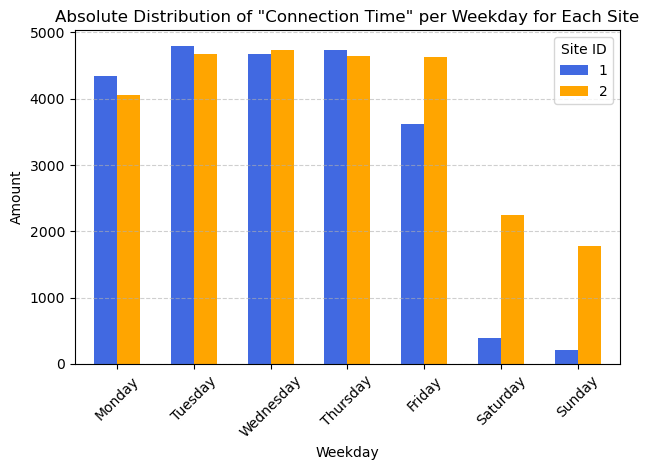

<Figure size 1200x600 with 0 Axes>

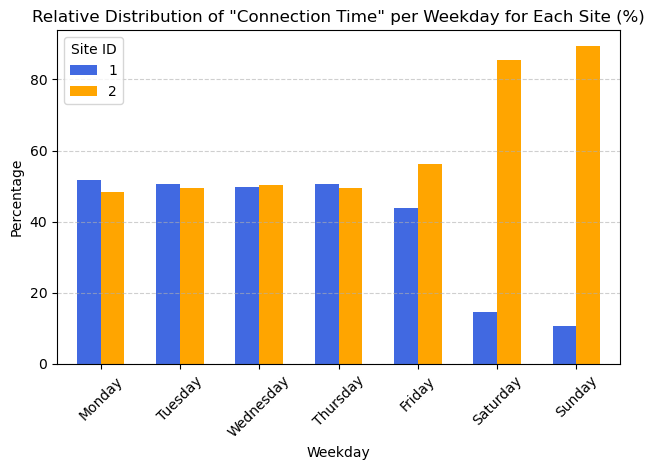

In [5]:
# Demonstrate how the number of charging events varies during the week

# Ensure the weekday names are labeled
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Retrieve the weekday
charging_sessions_data['weekday'] = charging_sessions_data['connectionTime'].dt.weekday

# Group data by weekday and site, and reindex to include all weekdays
absolute_counts_weekday_site = (
    charging_sessions_data.groupby(['weekday', 'siteID']).size().unstack(fill_value=0)
)
absolute_counts_weekday_site = absolute_counts_weekday_site.reindex(range(7), fill_value=0)  # Ensure all weekdays are present
absolute_counts_weekday_site.index = weekday_names  # Assign proper weekday names

# Calculation of the relative distribution (percentage) per location
relative_counts_weekday_site = absolute_counts_weekday_site.div(absolute_counts_weekday_site.sum(axis=1), axis=0) * 100

# Define colors for the sites
colors = ['royalblue', 'orange']

# Plotting the absolute distribution
plt.figure(figsize=(12, 6))
absolute_counts_weekday_site.plot(kind='bar', color=colors, width=0.6)
plt.title('Absolute Distribution of "Connection Time" per Weekday for Each Site')
plt.xlabel('Weekday')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Site ID')
plt.tight_layout()
plt.show()

# Plotting the relative distribution
plt.figure(figsize=(12, 6))
relative_counts_weekday_site.plot(kind='bar', color=colors, width=0.6)
plt.title('Relative Distribution of "Connection Time" per Weekday for Each Site (%)')
plt.xlabel('Weekday')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Site ID')
plt.tight_layout()
plt.show()

#### 1.3. Number of Charging Events during the Seasons

<Figure size 1200x600 with 0 Axes>

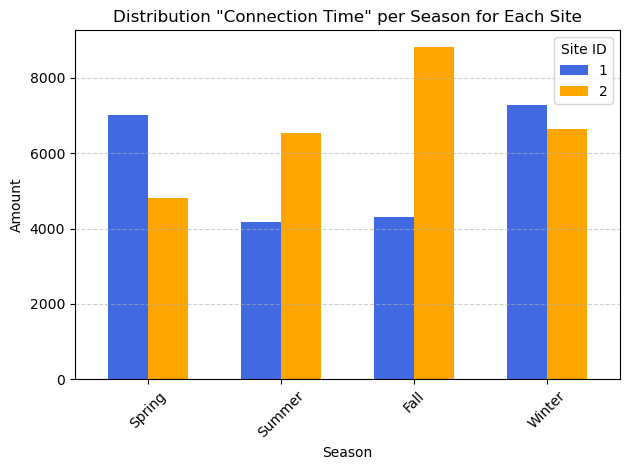

<Figure size 1200x600 with 0 Axes>

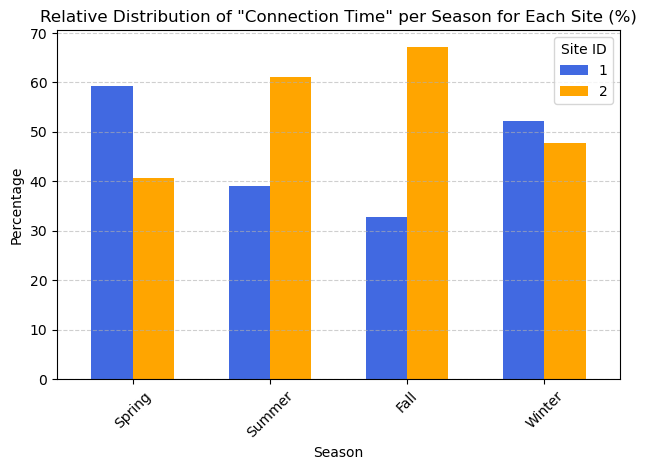

In [6]:
# Demonstrate how the number of charging events varies between the seasons

# The seasons in Los Angeles correspond to the quarters approximately, which is why these were used as a divider. 
# Ensure the quarter names are labeled
quarter_names = ['Spring', 'Summer', 'Fall', 'Winter']

# Retrieve the quarter
charging_sessions_data['quarter'] = charging_sessions_data['connectionTime'].dt.quarter

# Calculation of the absolute distribution per quarter and location
# Group data by quarter and site, and reindex to include all quarter
absolute_counts_quarter_site = (
    charging_sessions_data.groupby(['quarter', 'siteID']).size().unstack(fill_value=0)
)
absolute_counts_quarter_site = absolute_counts_quarter_site.reindex(range(1, 5), fill_value=0)  # Ensure all weekdays are present
absolute_counts_quarter_site.index = quarter_names  # Assign proper quarter names


# Calculation of the relative distribution (percentage) per location
relative_counts_quarter_site = absolute_counts_quarter_site.div(absolute_counts_quarter_site.sum(axis=1), axis=0) * 100

# Define colors for the sites
colors = ['royalblue', 'orange']

# Plotting the absolute distribution
plt.figure(figsize=(12, 6))
absolute_counts_quarter_site.plot(kind='bar', color=colors, width=0.6)
plt.title('Distribution "Connection Time" per Season for Each Site')
plt.xlabel('Season')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Site ID')
plt.tight_layout()
plt.show()

# Plotting the relative distribution
plt.figure(figsize=(12, 6))
relative_counts_quarter_site.plot(kind='bar', color=colors, width=0.6)
plt.title('Relative Distribution of "Connection Time" per Season for Each Site (%)')
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Site ID')
plt.tight_layout()
plt.show()

### 2. Key Performance Indicators (KPIs)

#### 2.1. Peak and Off-Utilization Time (per Site)

In [7]:
# Calculate hourly values of the KPI - Peak and Off-Utilization Time (per Site)
from datetime import datetime, timedelta 

# Create a DataFrame from the provided charging sessions data 
df = pd.DataFrame(charging_sessions_data)


# Convert 'connectionTime' and 'disconnectTime' columns from string to datetime objects.
# Note: This step is already done in Data_Preparation, so we can drop this if it is exported
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])

# Get unique site IDs
site_ids = df['siteID'].unique()

# Dictionary to store the results for each siteID
utilization_per_site = {}

# Iterate over each siteID
for site in site_ids:
    # Filter DataFrame for the current siteID -> site is either 1 or 2
    site_number = df[df['siteID'] == site]

    # Initialize an array to store the occupied minutes and the count of occupied minutes for each hour of the day.
    # The array will have 24 elements (one for each hour of the day, from 0 to 23).
    # Each element is a list where:
    # - index 0 will store the total number of occupied minutes in that hour.
    # - index 1 will store the count of occupied minutes (i.e., how many times a minute was occupied)
    minutes_array = [[0.0, 0.0] for _ in range(24)]  # Initialize each hour with [0.0, 0.0] (minutes, count)

    # Iterate through the DataFrame for site == 1 or for site == 2
    for row in site_number.itertuples():
        # Extract sessionID, connectionTime, and disconnectTime for each charging session
        sessionid = row.sessionID
        currenttime = row.connectionTime
        endtime = row.disconnectTime
        
        # Extract the hour and minute from the connectionTime and disconnectTime
        currenttimeStunde = currenttime.hour
        currenttimeMinute = currenttime.minute
        endtimeStunde = endtime.hour
        endtimeMinute = endtime.minute
        
        while currenttime < endtime:  # Keep going until we reach the disconnect time
            minutes_array[currenttimeStunde][0] += currenttimeMinute  # Add the minute to the corresponding hour in the minutes_array
            minutes_array[currenttimeStunde][1] += 1  # Increment the count for occupied minutes in this hour
        
            # Move to the next minute.
            if currenttime.minute == 59: # If it's the last minute of the hour
                if currenttime.hour == 23: # If it's also the last hour (23), we need to roll over to the next day.
                    currenttime = currenttime + timedelta(minutes=1) # Add 1 minute to move to the next day, reset the hour to 0 -> for that we imported timedelta
                else:
                    # Otherwise move to the next hour while resetting the minutes to 0
                    currenttime = currenttime.replace(minute=0, hour=currenttime.hour + 1)
            else:
                # If the minute is not 59, only increase the minute by 1
                currenttime = currenttime.replace(minute=currenttime.minute + 1)
                
        # print(f"Session ID: {sessionid}")
        # print(f"  Connection Time - Stunde: {connectiontimeStunde}, Minute: {connectiontimeMinute}")

    # print(minutes_array)

    # Now: Calculation of the hourly utilization

    # New array to store the hourly utilization (in percentage)
    utilizationPerHour_array = []

    # Iterate through all hours from 0 to 23 (the index corresponds to each hour of the day)
    for index in range(24):  
        occupied_minutes = minutes_array[index][0]  # Total occupied minutes in this hour
        count = minutes_array[index][1]  # Number of occupied minutes (i.e., how many times minutes were occupied)
        
        # Calculate the utilization percentage, but only if count > 0 (so no division by 0)
        if count > 0:
            utilization = (occupied_minutes / (count * 60)) * 100  # utilization in percentage 
        else:
            utilization = 0  # If no minutes were occupied, utilization = 0%
        
        # Append the calculated utilization for this hour to the list
        utilizationPerHour_array.append(utilization)
    
    # Store the results in the dictionary
    utilization_per_site[site] = utilizationPerHour_array

# print for each site
for site, utilizationPerHour_array in utilization_per_site.items():
    print(f"\nSite {site}:")
    for index, utilization in enumerate(utilizationPerHour_array):
        print(f"hour {index}: {utilization:.2f}% Utilization")



Site 1:
hour 0: 39.84% Utilization
hour 1: 40.44% Utilization
hour 2: 41.78% Utilization
hour 3: 41.25% Utilization
hour 4: 49.45% Utilization
hour 5: 43.41% Utilization
hour 6: 53.56% Utilization
hour 7: 38.56% Utilization
hour 8: 64.17% Utilization
hour 9: 4.72% Utilization
hour 10: 85.16% Utilization
hour 11: 71.81% Utilization
hour 12: 66.96% Utilization
hour 13: 57.56% Utilization
hour 14: 46.25% Utilization
hour 15: 39.97% Utilization
hour 16: 36.20% Utilization
hour 17: 47.77% Utilization
hour 18: 52.63% Utilization
hour 19: 50.12% Utilization
hour 20: 46.68% Utilization
hour 21: 49.95% Utilization
hour 22: 48.72% Utilization
hour 23: 43.67% Utilization

Site 2:
hour 0: 47.20% Utilization
hour 1: 50.78% Utilization
hour 2: 49.87% Utilization
hour 3: 46.62% Utilization
hour 4: 47.28% Utilization
hour 5: 47.50% Utilization
hour 6: 36.16% Utilization
hour 7: 45.70% Utilization
hour 8: 44.47% Utilization
hour 9: 44.27% Utilization
hour 10: 51.00% Utilization
hour 11: 78.08% Utiliza

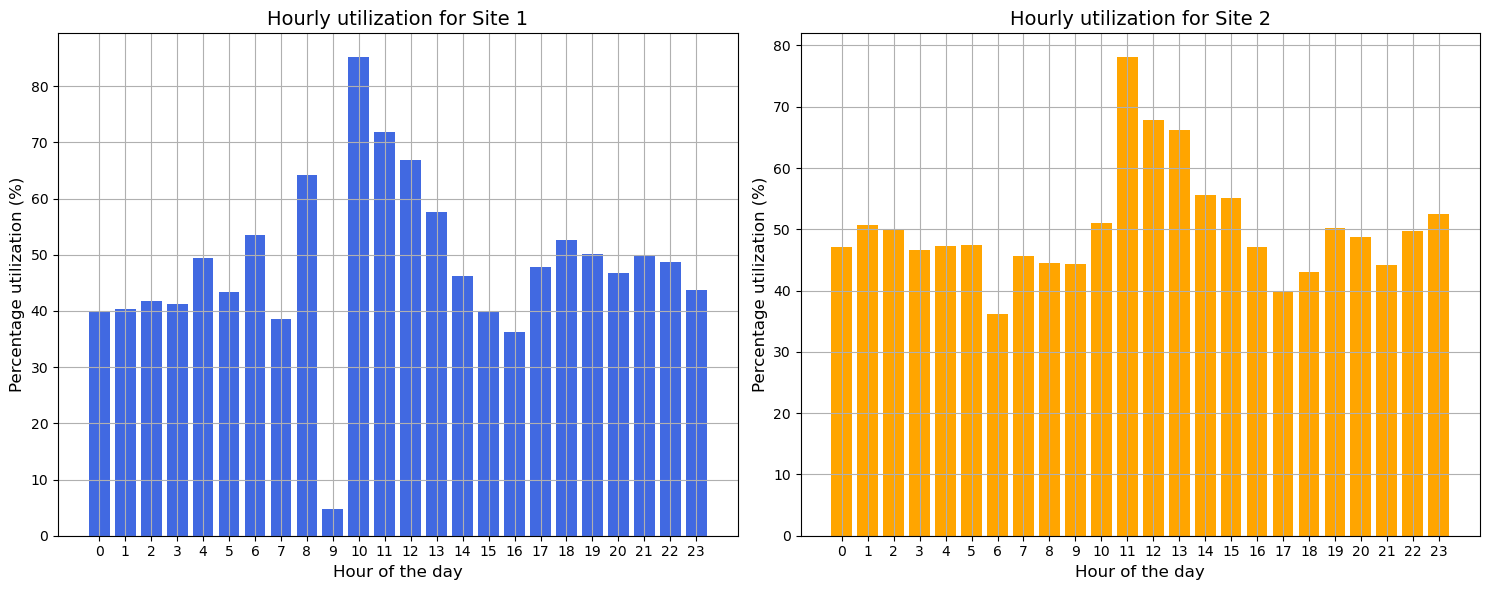

In [8]:
# Visualize hourly values of the KPIs over time

# bar chart

fig, axes = plt.subplots(1, len(site_ids), figsize=(15, 6)) 
# iterate over the siteIds
for i, site in enumerate(site_ids):
    # array for the current site
    utilizationPerHour_array = utilization_per_site[site]
    
    # Plot the bar chart using the hours as the x-axis and 'utilizationPerHour_array' as the y-axis values, set color - royalblue for site 1, orange for site 2
    color = 'orange' if site == 2 else 'royalblue'
    axes[i].bar(range(24), utilizationPerHour_array, color=color)

     # Axis labelling and titles
    axes[i].set_xlabel('Hour of the day', fontsize=12)
    axes[i].set_ylabel('Percentage utilization (%)', fontsize=12)
    axes[i].set_title(f'Hourly utilization for Site {site}', fontsize=14)

    axes[i].set_xticks(range(24)) # Ensure that all hours (0 to 23) are shown on the X-axis
    axes[i].grid(True)  # Add a grid

plt.tight_layout() # Adjust the layout of the plot to prevent overlapping of labels or elements

plt.show() # Display the plot

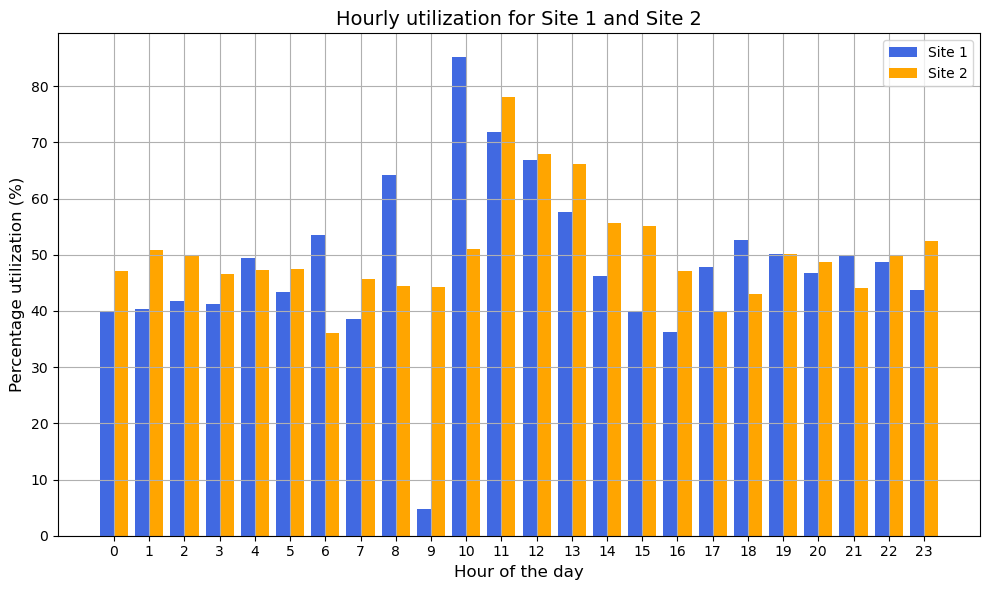

In [9]:
# visualize utilization time per hour for both sites in barchart

fig, ax = plt.subplots(figsize=(10, 6))  # Eine einzelne Achse

# The width of the beams (so that they fit next to each other)
bar_width = 0.4


x = range(24)  # X values from 0 to 23 for each hour

#draw the hourly utilisation for site 1 in royalblue
ax.bar([i - bar_width / 2 for i in x], utilization_per_site[1], color='royalblue', width=bar_width, label='Site 1')

# Draw the hourly utilisation for Site 2 in orange, shift the X values by bar_width
ax.bar([i + bar_width / 2 for i in x], utilization_per_site[2], color='orange', width=bar_width, label='Site 2')

# Axis labelling and titles
ax.set_xlabel('Hour of the day', fontsize=12)
ax.set_ylabel('Percentage utilization (%)', fontsize=12)
ax.set_title('Hourly utilization for Site 1 and Site 2', fontsize=14)


ax.set_xticks(range(24))  # Ensure that all hours (0 to 23) are shown on the X-axis
ax.grid(True)  # add a grid 

ax.legend() # add a legend

plt.tight_layout() # Adjust the layout of the plot to prevent overlapping of labels or elements

plt.show() # Display the plot

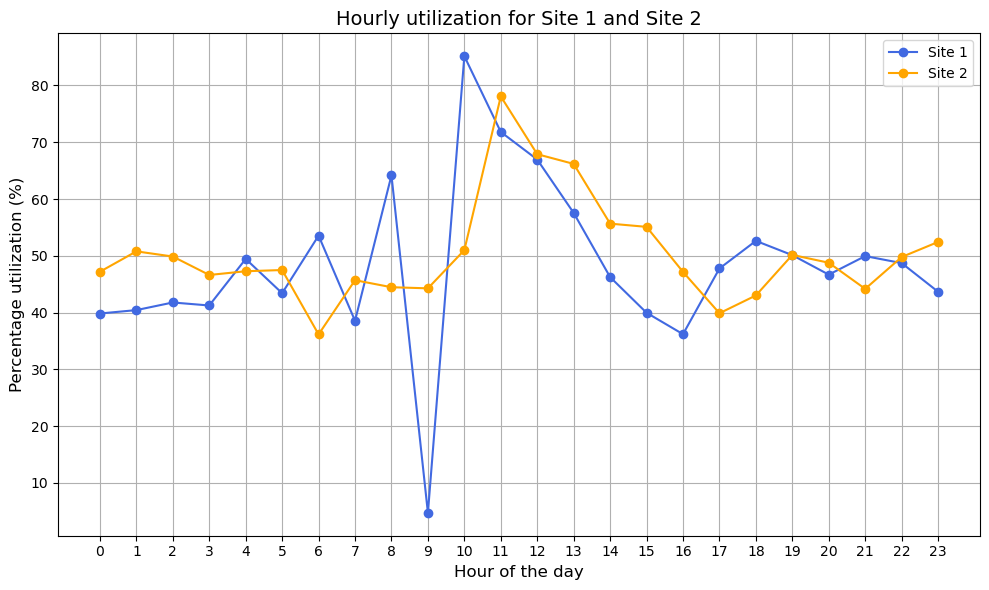

In [10]:
# Visualize utilization time per hour for both sites in line chart

fig, ax = plt.subplots(figsize=(10, 6))  # One axis for the plot

# Draw the hourly utilization for Site 1 in royalblue (line chart)
ax.plot(range(24), utilization_per_site[1], color='royalblue', marker='o', label='Site 1')

# Draw the hourly utilization for Site 2 in orange (line chart), with markers
ax.plot(range(24), utilization_per_site[2], color='orange', marker='o', label='Site 2')

# Axis labelling and titles
ax.set_xlabel('Hour of the day', fontsize=12)
ax.set_ylabel('Percentage utilization (%)', fontsize=12)
ax.set_title('Hourly utilization for Site 1 and Site 2', fontsize=14)

# Set x-ticks for all hours (0 to 23)
ax.set_xticks(range(24))  

# Add grid for better readability
ax.grid(True)  

# Add a legend to label the sites
ax.legend()

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Display the plot
plt.show()

#### 2.2. Average Idle Time per Hour per SiteID

In [11]:
# split data into 2 sites
site1_sessions = charging_sessions_data[charging_sessions_data["siteID"] == 1]
site2_sessions = charging_sessions_data[charging_sessions_data["siteID"] == 2]

# calculate idle time in hours for each site
disconnect_time1 = site1_sessions["disconnectTime"]
done_charging_time1 = site1_sessions["doneChargingTime"]
disconnect_time2 = site2_sessions["disconnectTime"]
done_charging_time2 = site2_sessions["doneChargingTime"]

# convert idle time from days into hours
idle_time1 = (disconnect_time1 - done_charging_time1).dt.total_seconds() / 60
idle_time1 = idle_time1 / 60
hours1 = disconnect_time1.dt.hour
idle_time2 = (disconnect_time2 - done_charging_time2).dt.total_seconds() / 60
idle_time2 = idle_time2 / 60
hours2 = disconnect_time2.dt.hour

# aggregate: Calculate average idle time per hour
unique_hours = np.arange(24)  # 24 hours in a day
average_idle_time1 = np.array([
    idle_time1[hours1 == hour].mean() for hour in unique_hours
])
average_idle_time2 = np.array([
    idle_time2[hours2 == hour].mean() for hour in unique_hours
])

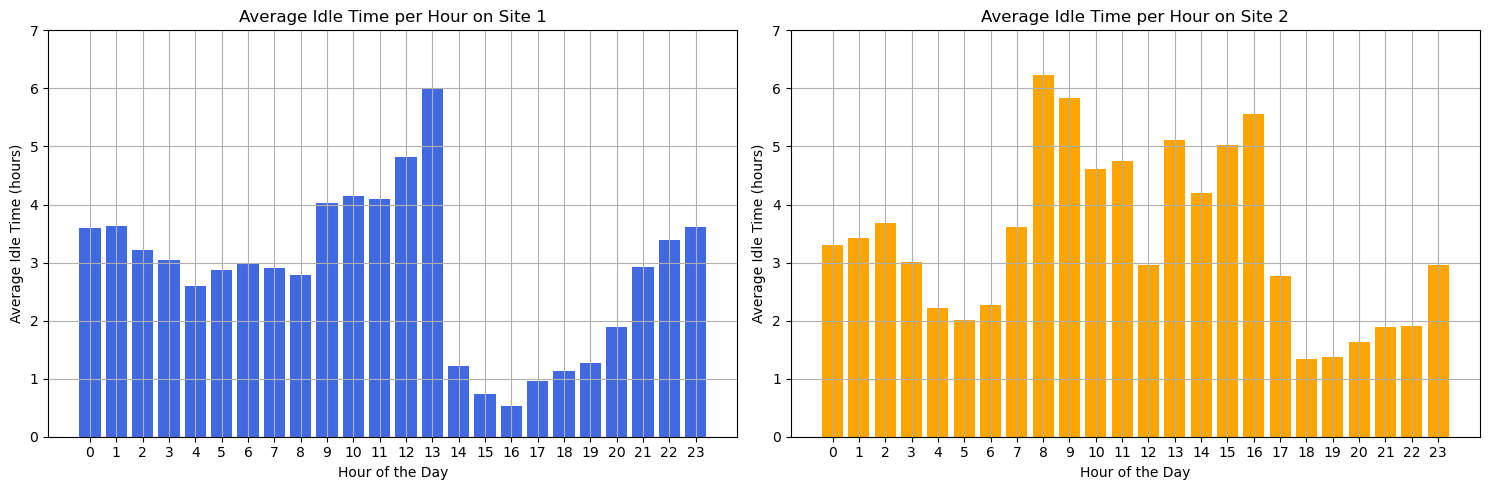

In [12]:
# visualize average idle time of each site side by side in bar chart
# create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# visualize idle time per hour for the first site
axs[0].bar(unique_hours, average_idle_time1, color='royalblue')
axs[0].grid(True)

axs[0].set_title("Average Idle Time per Hour on Site 1")
axs[0].set_xlabel("Hour of the Day")
axs[0].set_ylabel("Average Idle Time (hours)")
axs[0].set_xticks(range(24))
axs[0].set_yticks(range(8))

# visualize idle time per hour for the second site
axs[1].bar(unique_hours, average_idle_time2, color='orange')
axs[1].grid(True)

axs[1].set_title("Average Idle Time per Hour on Site 2")
axs[1].set_xlabel("Hour of the Day")
axs[1].set_ylabel("Average Idle Time (hours)")
axs[1].set_xticks(range(24))
axs[1].set_yticks(range(8))

# adjust layout
plt.tight_layout()
plt.show()

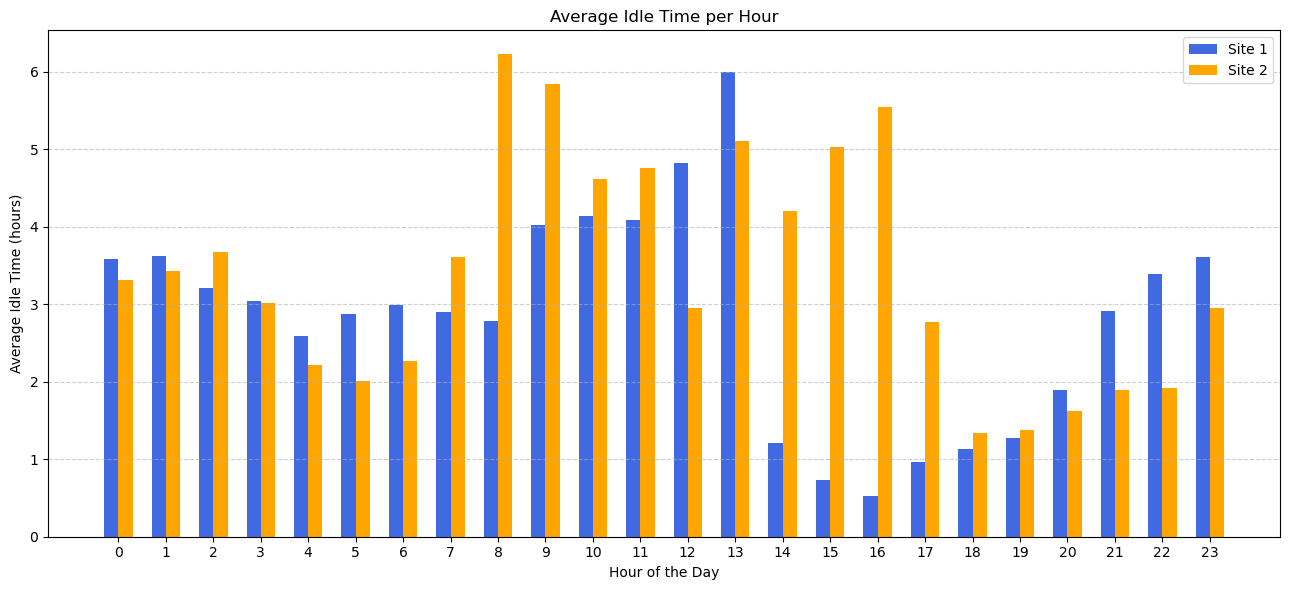

In [13]:
# visualize idle time per hour for both sites in barchart
bar_width = 0.3

plt.figure(figsize=(13, 6))
plt.bar(unique_hours - bar_width / 2, average_idle_time1, width=bar_width, color = "royalblue", label='Site 1')
plt.bar(unique_hours + bar_width / 2, average_idle_time2, width=bar_width, color = "orange", label='Site 2')
plt.grid(axis='y', visible=True, linestyle='--', alpha=0.6)

plt.title("Average Idle Time per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Idle Time (hours)")
plt.xticks(range(24))
plt.legend()

# adjust layout
plt.tight_layout()
plt.show()

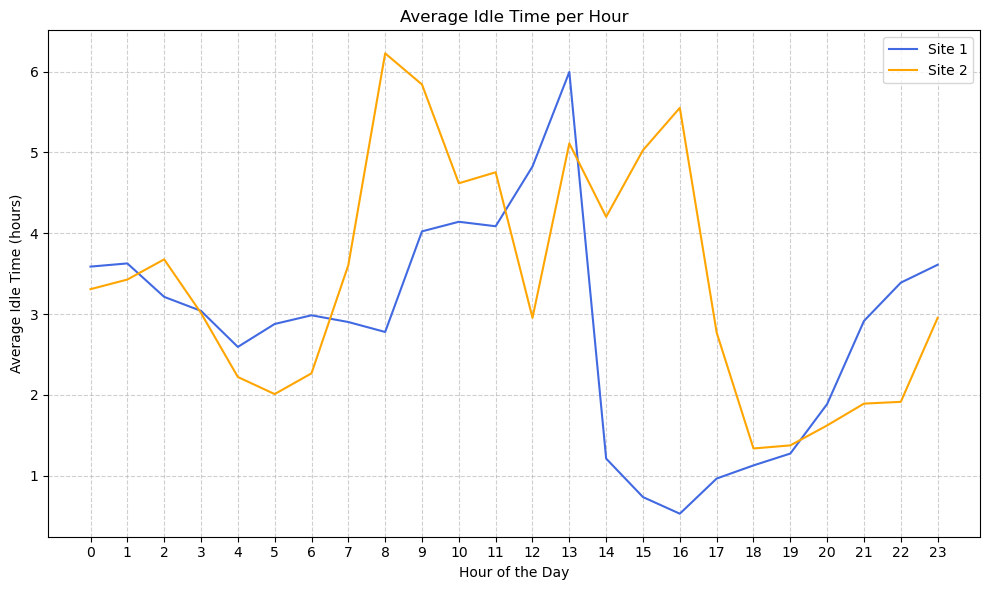

In [14]:
# visualize idle time per hour for both sites in linechart
plt.figure(figsize=(10, 6))
plt.plot(unique_hours, average_idle_time1, color = "royalblue", label='Site 1')
plt.plot(unique_hours, average_idle_time2, color = "orange", label='Site 2')
plt.grid(visible=True, linestyle='--', alpha=0.6)

plt.title("Average Idle Time per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Idle Time (hours)")
plt.xticks(range(24))
plt.legend()

# adjust layout
plt.tight_layout()
plt.show()

#### 2.3. Average Energy Delivered per Session per Site per Hour

In [15]:
# split dataframe into 2 sites
site1_sessions = charging_sessions_data[charging_sessions_data["siteID"] == 1]
site2_sessions = charging_sessions_data[charging_sessions_data["siteID"] == 2]

# function that filters data by hour
def filterSessionsByHour(hour, df):
    hour = df[df['connectionTime'].dt.hour == hour]
    return hour

def avgEnergyToList(df):
    energyList = []
    for i in range(24):
        hour = filterSessionsByHour(i, df)
        totalEnergy = hour.kWhDelivered.sum()
        # calculute average energy by summing up energy delivered in the hour and dividing by number of sessions
        avgEnergy = totalEnergy / len(hour) 
        energyList.append(avgEnergy)
    return energyList

energyList_site1 = avgEnergyToList(site1_sessions)
energyList_site2 = avgEnergyToList(site2_sessions)


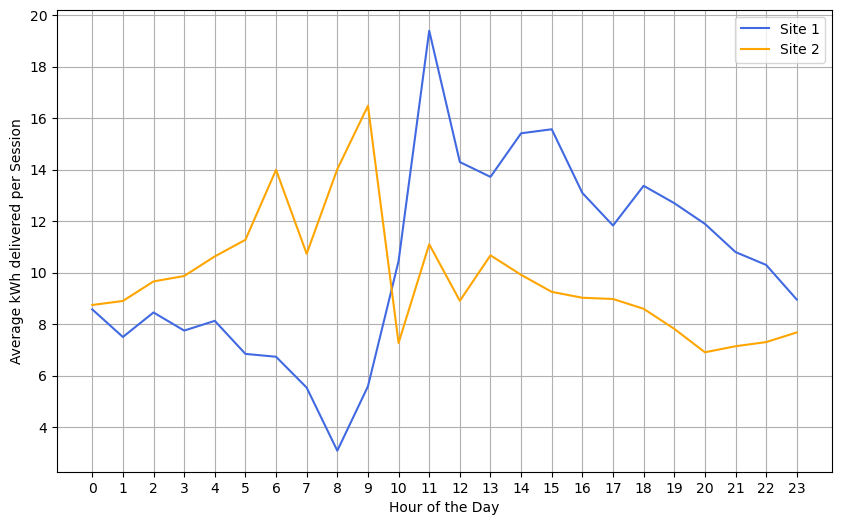

In [16]:
# visualize average energy
import matplotlib.pyplot as plt
import numpy as np

hours = range(24)
y_1 = np.array(energyList_site1)
y_2 = np.array(energyList_site2)

plt.figure(figsize=(10,6))
plt.plot(hours, y_1, color = "royalBlue", label='Site 1')
plt.plot(hours, y_2, color = "orange", label='Site 2')
plt.xticks(range(24))
plt.xlabel("Hour of the Day")
plt.ylabel("Average kWh delivered per Session")
plt.legend()
plt.grid(True)
plt.show()

[83.52, 87.5, 91.09, 86.67, 92.41, 97.67, 100.0, 92.86, 80.0, 100.0, 100.0, 90.91, 89.96, 85.84, 84.59, 84.12, 83.24, 82.94, 81.05, 81.41, 84.42, 82.96, 81.63, 82.86]
[35.89, 36.18, 35.04, 34.43, 42.68, 28.88, 31.43, 25.69, 36.84, 42.86, 19.23, 4.35, 23.08, 39.08, 35.0, 41.63, 56.82, 65.86, 63.3, 50.51, 50.93, 50.44, 43.64, 37.3]


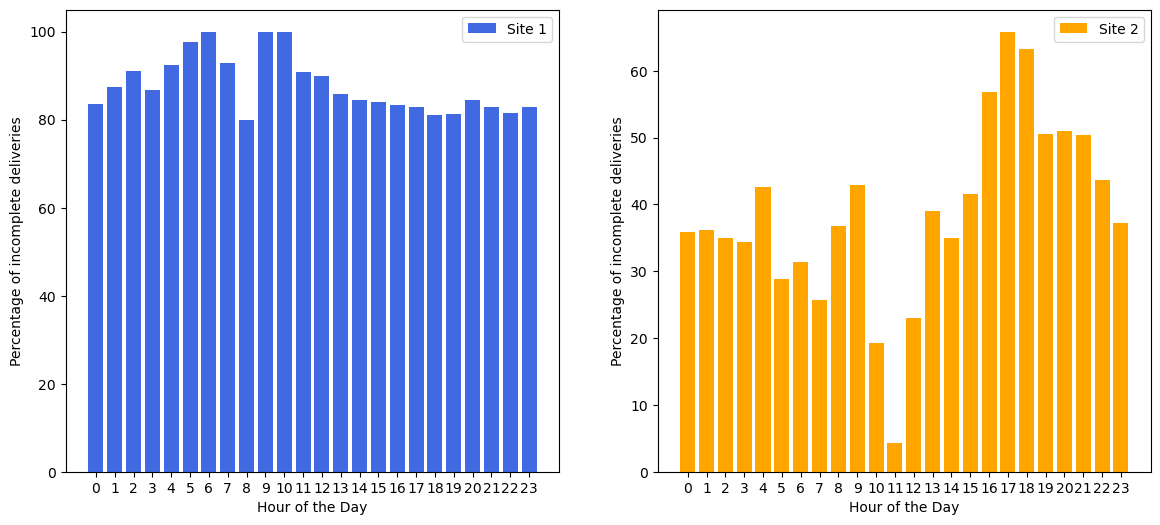

In [17]:
# An incomplete delivery is defined by a session that delivered less energy than requested, 
# although driver disconnected after charging was done
def underDeliveredToList(df):
    percentageList = []
    for i in range(24):
        hour = filterSessionsByHour(i, df)
        imcompleteSess = hour[(hour['kWhDelivered'] < hour['kWhRequested']) & (hour['disconnectTime'] >= hour['doneChargingTime']) ]
        percentage = round(len(imcompleteSess) / len(hour) * 100,2)
        percentageList.append(percentage)
    return percentageList


incompleteDelivery_site1 = underDeliveredToList(site1_sessions)
incompleteDelivery_site2 = underDeliveredToList(site2_sessions)

print(incompleteDelivery_site1)
print(incompleteDelivery_site2)

hours = range(24)
y_1 = np.array(incompleteDelivery_site1)
y_2 = np.array(incompleteDelivery_site2)

plt.figure(figsize=(14, 6)) 

plt.subplot(1, 2, 1)
plt.bar(hours, y_1, color = "royalBlue", label='Site 1')
plt.xticks(range(24), labels=range(24))
plt.xlabel("Hour of the Day")
plt.ylabel("Percentage of incomplete deliveries")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(hours, y_2, color = "orange", label='Site 2')
plt.xticks(range(24), labels=range(24))
plt.xlabel("Hour of the Day")
plt.ylabel("Percentage of incomplete deliveries")

plt.legend()
plt.show()

### 3. Site Characteristics

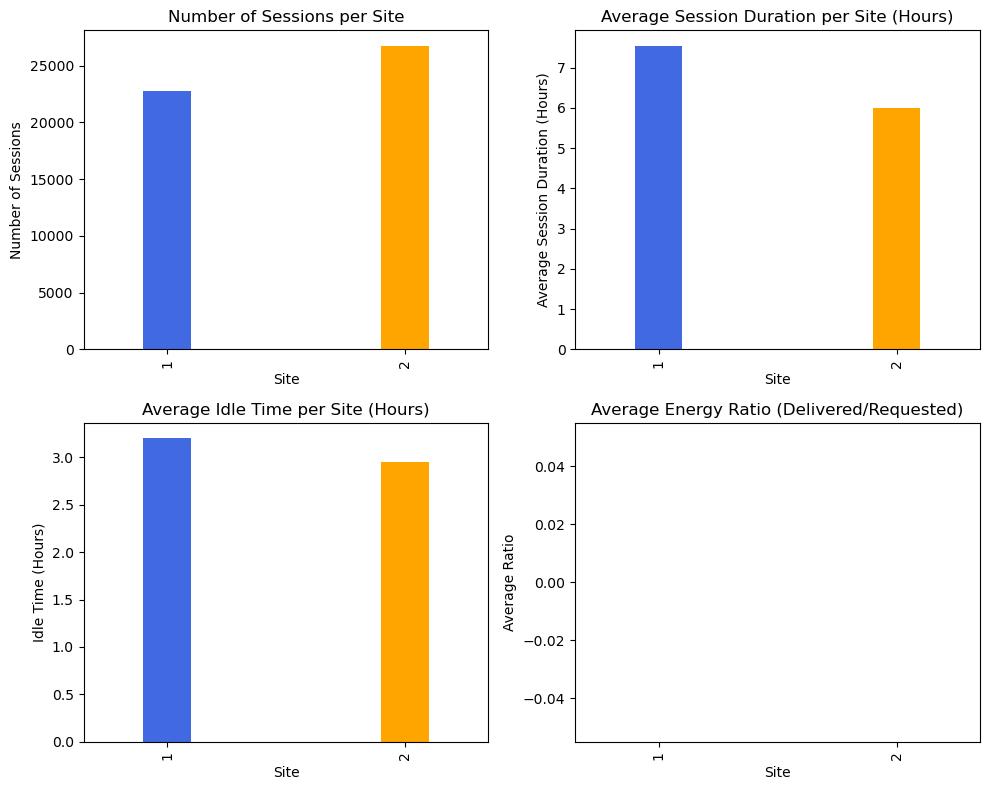

Number of sessions per site:
siteID
1    22776
2    26786
dtype: int64

A higher number of sessions indicates a public site due to higher frequency of usage.

Average session duration per site (hours):
siteID
1    7.552148
2    5.995264
Name: session_duration, dtype: float64

Longer session durations suggest a private site where users charge for extended periods.

Average idle time per site (hours):
siteID
1    3.203218
2    2.947866
Name: idle_time, dtype: float64

Higher idle times are typical at private sites where users leave vehicles connected longer after charging is complete.

Average energy ratio per site (delivered/requested):
siteID
1    inf
2    inf
Name: energy_ratio, dtype: float64

Higher energy ratios indicate that users are completing their charging sessions, typical at private sites.

Number of unique users per site:
siteID
1    420
2    402
Name: userID, dtype: int64

A larger number of unique users suggests a public site, while fewer unique users suggest a private si

In [18]:
# Add a column for session duration in hours
# The session duration is calculated as the difference between connection and disconnection times
charging_sessions_data["session_duration"] = (
    (charging_sessions_data["disconnectTime"] - charging_sessions_data["connectionTime"]).dt.total_seconds() / 3600
)

# Calculate idle time
# Idle time is the duration between when the charging completes and when the vehicle is disconnected
charging_sessions_data["idle_time"] = (
    (charging_sessions_data["disconnectTime"] - charging_sessions_data["doneChargingTime"]).dt.total_seconds() / 3600
)

# Add a column for energy delivered per requested energy
# This indicates how much of the requested energy was delivered
charging_sessions_data["energy_ratio"] = (
    charging_sessions_data["kWhDelivered"] / charging_sessions_data["kWhRequested"]
)

# Count the number of sessions per site
sessions_per_site = charging_sessions_data.groupby("siteID").size()

# Average session duration per site
# Represents the typical time a vehicle is connected to the charger
avg_duration_per_site = charging_sessions_data.groupby("siteID")["session_duration"].mean()

# Average idle time per site
# Highlights the average time vehicles remain at the charger after charging is complete
avg_idle_time_per_site = charging_sessions_data.groupby("siteID")["idle_time"].mean()

# Average energy ratio per site
# Reflects how much of the requested energy was delivered, indicating charging efficiency
avg_energy_ratio_per_site = charging_sessions_data.groupby("siteID")["energy_ratio"].mean()

# Number of unique users per site
# Helps differentiate between private (few recurring users) and public (many different users) hubs
unique_users_per_site = charging_sessions_data.groupby("siteID")["userID"].nunique()

# Visualization of differences between sites
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Reduce bar width
bar_width = 0.2 # Adjust to make bars thinner

# Number of sessions per site
sessions_per_site.plot(kind="bar", ax=axes[0, 0], color=["royalblue", "orange"], width=bar_width)
axes[0, 0].set_title("Number of Sessions per Site")
axes[0, 0].set_xlabel("Site")
axes[0, 0].set_ylabel("Number of Sessions")

# Average session duration per site
avg_duration_per_site.plot(kind="bar", ax=axes[0, 1], color=["royalblue", "orange"], width=bar_width)
axes[0, 1].set_title("Average Session Duration per Site (Hours)")
axes[0, 1].set_xlabel("Site")
axes[0, 1].set_ylabel("Average Session Duration (Hours)")

# Average idle time per site
avg_idle_time_per_site.plot(kind="bar", ax=axes[1, 0], color=["royalblue", "orange"], width=bar_width)
axes[1, 0].set_title("Average Idle Time per Site (Hours)")
axes[1, 0].set_xlabel("Site")
axes[1, 0].set_ylabel("Idle Time (Hours)")

# Average energy ratio per site
avg_energy_ratio_per_site.plot(kind="bar", ax=axes[1, 1], color=["royalblue", "orange"], width=bar_width)
axes[1, 1].set_title("Average Energy Ratio (Delivered/Requested)")
axes[1, 1].set_xlabel("Site")
axes[1, 1].set_ylabel("Average Ratio")

plt.tight_layout()
plt.show()

# Print results with explanations
print("Number of sessions per site:")
print(sessions_per_site)
print("\nA higher number of sessions indicates a public site due to higher frequency of usage.\n")

print("Average session duration per site (hours):")
print(avg_duration_per_site)
print("\nLonger session durations suggest a private site where users charge for extended periods.\n")

print("Average idle time per site (hours):")
print(avg_idle_time_per_site)
print("\nHigher idle times are typical at private sites where users leave vehicles connected longer after charging is complete.\n")

print("Average energy ratio per site (delivered/requested):")
print(avg_energy_ratio_per_site)
print("\nHigher energy ratios indicate that users are completing their charging sessions, typical at private sites.\n")

print("Number of unique users per site:")
print(unique_users_per_site)
print("\nA larger number of unique users suggests a public site, while fewer unique users suggest a private site.\n")

In [19]:
charging_sessions_data.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,...,kWhRequested,milesRequested,minutesAvailable,requestedDeparture,hour,weekday,quarter,session_duration,idle_time,energy_ratio
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,...,25.0,100.0,463.0,2020-01-02 20:51:54,13,3,1,6.039167,1.661111,1.000640
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,...,70.0,250.0,595.0,2020-01-02 23:31:50,13,3,1,9.025278,2.337778,0.472814
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,...,8.0,20.0,60.0,2020-01-02 14:56:35,13,3,1,10.713056,8.071111,0.815125
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,...,8.0,20.0,65.0,2020-01-02 15:04:58,13,3,1,2.644722,1.331667,0.294375
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,...,16.0,40.0,504.0,2020-01-02 22:24:01,14,3,1,8.144167,3.852778,0.835938


In [20]:
charging_sessions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49562 entries, 0 to 49561
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   id                      49562 non-null  object             
 1   connectionTime          49562 non-null  datetime64[ns, UTC]
 2   disconnectTime          49562 non-null  datetime64[ns, UTC]
 3   doneChargingTime        49562 non-null  datetime64[ns, UTC]
 4   kWhDelivered            49562 non-null  float64            
 5   sessionID               49562 non-null  object             
 6   siteID                  49562 non-null  int64              
 7   spaceID                 49562 non-null  object             
 8   stationID               49562 non-null  object             
 9   timezone                49562 non-null  object             
 10  userID                  49562 non-null  object             
 11  userInputs              49562 non-null  o

In [21]:
# Export dataframe with new attributes
charging_sessions_data.to_csv('cleaned_data.csv', index=False)